In [1]:
# evaluate candidates identified by reaction_recommender 
import collections
import itertools
import libsbml
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline  

script_path = "/Users/woosubs/Desktop/AutomateAnnotation/reaction_recommender/reaction_recommender/"
os.sys.path.append(script_path)

# import get_annotation as ga
from reaction_recommender import annotation_container as ac
from reaction_recommender import reaction_recommender as recommender

BASE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/'
BIOMD_12 = 'BIOMD0000000012.xml'
DATA_DIR = os.path.join(BASE_DIR, "DATA")
RHEA_DIR = os.path.join(DATA_DIR, "rhea")
# BioModel files
BIOMODEL_DIR = os.path.join(DATA_DIR, "biomodels/curated_biomodels_31mar2021")
biomd_files = [f for f in os.listdir(BIOMODEL_DIR) if f[-4:] == ".xml"]
print(len(biomd_files))
biomd_fpaths = [os.path.join(BIOMODEL_DIR, one_file) for one_file in biomd_files]

# BiGG files
BIGG_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/DATA/bigg'
ecoli_fpath = os.path.join(BIGG_DIR, "e_coli_core.xml")
bigg_files = [f for f in os.listdir(BIGG_DIR) if f[-4:]=='.xml']
bigg_fpaths = [os.path.join(BIGG_DIR, f) for f in bigg_files]
print(len(bigg_files))
one_fpath = bigg_fpaths[0]

1000
108


In [2]:
# Dictionaries
with open(os.path.join(DATA_DIR, 'all_shortened_chebi_to_formula_19nov2021.pkl'), 'rb') as f:
  ref_shortened_chebi_to_formula = pickle.load(f)
# below is full version
with open(os.path.join(DATA_DIR, 'all_possible_chebi_to_formula_12nov2021.pkl'), 'rb') as f:
  ref_full_chebi_to_formula = pickle.load(f)
# map secondary id to primary id
with open(os.path.join(DATA_DIR, 'chebi_second2prime_8nov2021.pickle'), 'rb') as f:
  ref_second2prime_dict = pickle.load(f)
# RHEA All Ids to Bi Id (KEGG Mappable)
with open(os.path.join(RHEA_DIR, 'rhea_all2bi.pkl'), 'rb') as f:
  ref_rhea2bi = pickle.load(f)
with open(os.path.join(RHEA_DIR, 'rhea_all2master.pkl'), 'rb') as f:
  ref_rhea2master = pickle.load(f)
with open(os.path.join(RHEA_DIR, 'rhea2chebi_reference.pkl'), 'rb') as f:
  ref_rhea2chebi = pickle.load(f)

In [3]:
df = pd.read_csv(os.path.join(RHEA_DIR, 'rhea_string_equation.tsv'), sep='\t', index_col=0)

In [4]:
df.head()

,equation
id,
RHEA:10000,H2O + pentanamide = NH4(+) + pentanoate
RHEA:10004,benzyl isothiocyanate = benzyl thiocyanate
RHEA:10008,[protein]-dithiol + a hydroperoxide = [protein...
RHEA:10012,(R)-6-hydroxynicotine + H2O + O2 = 6-hydroxyps...
RHEA:10016,H2O + O-sinapoylcholine = choline + E-sinapate...


In [72]:
recom = recommender.ReactionRecommender(model_file=os.path.join(BIGG_DIR, ecoli_fpath))

In [73]:
print(list(recom.reac_dict.keys()))

['R_PFK', 'R_PFL', 'R_PGI', 'R_PGK', 'R_PGL', 'R_ACALD', 'R_AKGt2r', 'R_PGM', 'R_PIt2r', 'R_ALCD2x', 'R_ACALDt', 'R_ACKr', 'R_PPC', 'R_ACONTa', 'R_ACONTb', 'R_ATPM', 'R_PPCK', 'R_ACt2r', 'R_PPS', 'R_ADK1', 'R_AKGDH', 'R_ATPS4r', 'R_PTAr', 'R_PYK', 'R_BIOMASS_Ecoli_core_w_GAM', 'R_PYRt2', 'R_CO2t', 'R_RPE', 'R_CS', 'R_RPI', 'R_SUCCt2_2', 'R_CYTBD', 'R_D_LACt2', 'R_ENO', 'R_SUCCt3', 'R_ETOHt2r', 'R_SUCDi', 'R_SUCOAS', 'R_TALA', 'R_THD2', 'R_TKT1', 'R_TKT2', 'R_TPI', 'R_EX_ac_e', 'R_EX_acald_e', 'R_EX_akg_e', 'R_EX_co2_e', 'R_EX_etoh_e', 'R_EX_for_e', 'R_EX_fru_e', 'R_EX_fum_e', 'R_EX_glc__D_e', 'R_EX_gln__L_e', 'R_EX_glu__L_e', 'R_EX_h_e', 'R_EX_h2o_e', 'R_EX_lac__D_e', 'R_EX_mal__L_e', 'R_EX_nh4_e', 'R_EX_o2_e', 'R_EX_pi_e', 'R_EX_pyr_e', 'R_EX_succ_e', 'R_FBA', 'R_FBP', 'R_FORt2', 'R_FORt', 'R_FRD7', 'R_FRUpts2', 'R_FUM', 'R_FUMt2_2', 'R_G6PDH2r', 'R_GAPD', 'R_GLCpts', 'R_GLNS', 'R_GLNabc', 'R_GLUDy', 'R_GLUN', 'R_GLUSy', 'R_GLUt2r', 'R_GND', 'R_H2Ot', 'R_ICDHyr', 'R_ICL', 'R_LDH_D', '

In [80]:
rid = 'R_PFK'
max_rid_len = 0
max_rid_name = ''
for rid in list(recom.reac_dict.keys()):
  candidates = recom.getCandidatesByReactionId(reaction_ids=rid)
  len_cands = len(candidates[rid])
  if len_cands > max_rid_len and len_cands < 200:
    max_rid_len = len_cands
    max_rid_name = rid

In [81]:
max_rid_len

189

In [92]:
cand_dict = recom.getCandidatesByReactionId(reaction_ids='R_AKGt2r')
print(recom.getCandidateReport(cand_dict, df))

Reaction R_AKGt2r: M_akg_e + M_h_e = M_akg_c + M_h_c
Has possible RHEA IDs as below:

0. <RHEA:28947> H(+)(out) + L-arabinose(in) = H(+)(in) + L-arabinose(out)
1. <RHEA:28951> H(+)(in) + L-arabinose(in) = H(+)(out) + L-arabinose(out)
2. <RHEA:28959> D-xylose(in) + H(+)(in) = D-xylose(out) + H(+)(out)
3. <RHEA:29011> 2-oxoglutarate(in) + H(+)(in) = 2-oxoglutarate(out) + H(+)(out)
4. <RHEA:29991> H(+)(in) + L-lyxose(in) = H(+)(out) + L-lyxose(out)
5. <RHEA:66428> D-arabinose(out) + H(+)(out) = D-arabinose(in) + H(+)(in)
6. <RHEA:11868> D-arabinitol + NADP(+) = D-ribulose + H(+) + NADPH
7. <RHEA:13449> 2-hydroxyglutarate + NAD(+) = 2-oxoglutarate + H(+) + NADH
8. <RHEA:13861> D-xylose + NAD(+) = D-xylono-1,5-lactone + H(+) + NADH
9. <RHEA:15301> D-apiitol + NAD(+) = aldehydo-D-apiose + H(+) + NADH
10. <RHEA:15789> L-xylose + NADP(+) = H(+) + L-xylono-1,4-lactone + NADPH
11. <RHEA:16381> L-arabinitol + NAD(+) = H(+) + L-xylulose + NADH
12. <RHEA:17025> NADP(+) + xylitol = H(+) + L-xylulose

In [93]:
# Now, check it with actual term (considered as gold standard)
anot_container = ac.AnnotationContainer(model_file=os.path.join(BIGG_DIR, ecoli_fpath))
true_vaules = getTrueReactionAnnotation(container=anot_container,
                                          reaction_id='R_AKGt2r',
                                          qualifier_type='rhea')

In [94]:
true_vaules

['RHEA:29011', 'RHEA:29013', 'RHEA:29012', 'RHEA:29014']

In [5]:
def getTrueReactionAnnotation(container, reaction_id, qualifier_type='rhea'):
  """
  Get the list of true reaction annotations, 
  so that we can check whether 
  the predicted id was correct. 
  returrn: list-str/None
  """
  one_anot = container.model.getReaction(reaction_id).getAnnotationString()
  rhea_nums = container.getQualifierFromString(input_str=one_anot, qualifier=qualifier_type)
  if rhea_nums:
    return['RHEA:'+val for val in rhea_nums]
  else:
    return None

In [49]:
# test the method
# getTrueReactionAnnotation(container=anot_container, reaction_id='R_PFK', qualifier_type='rhea')

In [44]:
CANDIDATE_NUM = 5
all_reaction_ids = list(recom.reac_dict.keys())
one_reaction_id = all_reaction_ids[0]
result = []
for one_reaction_id in all_reaction_ids:
  true_vaules = getTrueReactionAnnotation(container=anot_container,
                                          reaction_id=one_reaction_id,
                                          qualifier_type='rhea')
  if true_vaules is None:
    result.append(None)
  else:
    candidates = recom.getCandidatesByReactionId(reaction_ids=one_reaction_id)
    ranked_candidates = recom.sortCandidates(candidate_list=candidates[one_reaction_id])[:CANDIDATE_NUM]
    intersects = [val in ranked_candidates for val in true_vaules]
    # determine if result is correct
    result.append(any(intersects))

In [48]:
valid_result = [val for val in result if val is not None]
np.sum(valid_result) / len(valid_result)

0.967741935483871

In [ ]:
# Now, get the statistic of all models?! 

In [33]:
CANDIDATE_NUM = 3
k_precision_3 = []
for idx, one_fpath in enumerate(bigg_fpaths):
  if idx % 10 == 0:
    print("We are at", idx)
  recom = recommender.ReactionRecommender(model_file=one_fpath)
  anot_container = ac.AnnotationContainer(model_file=one_fpath)
  all_reaction_ids = list(recom.reac_dict.keys())
  one_reaction_id = all_reaction_ids[0]
  result = []
  for one_reaction_id in all_reaction_ids:
    true_vaules = getTrueReactionAnnotation(container=anot_container,
                                            reaction_id=one_reaction_id,
                                            qualifier_type='rhea')
    if true_vaules is None:
      result.append(None)
    else:
      candidates = recom.getCandidatesByReactionId(reaction_ids=one_reaction_id)
      ranked_candidates = recom.sortCandidates(candidate_list=candidates[one_reaction_id])[:CANDIDATE_NUM]
      intersects = [val in ranked_candidates for val in true_vaules]
     # determine if result is correct 
      result.append(any(intersects))
  valid_result = [val for val in result if val is not None]
  k_precision_3.append(np.sum(valid_result) / len(valid_result))

We are at 0
We are at 10
We are at 20
We are at 30
We are at 40
We are at 50
We are at 60
We are at 70
We are at 80
We are at 90
We are at 100


In [34]:
CANDIDATE_NUM = 20
k_precision_20 = []
for idx, one_fpath in enumerate(bigg_fpaths):
  if idx % 10 == 0:
    print("We are at", idx)
  recom = recommender.ReactionRecommender(model_file=one_fpath)
  anot_container = ac.AnnotationContainer(model_file=one_fpath)
  all_reaction_ids = list(recom.reac_dict.keys())
  one_reaction_id = all_reaction_ids[0]
  result = []
  for one_reaction_id in all_reaction_ids:
    true_vaules = getTrueReactionAnnotation(container=anot_container,
                                            reaction_id=one_reaction_id,
                                            qualifier_type='rhea')
    if true_vaules is None:
      result.append(None)
    else:
      candidates = recom.getCandidatesByReactionId(reaction_ids=one_reaction_id)
      ranked_candidates = recom.sortCandidates(candidate_list=candidates[one_reaction_id])[:CANDIDATE_NUM]
      intersects = [val in ranked_candidates for val in true_vaules]
     # determine if result is correct 
      result.append(any(intersects))
  valid_result = [val for val in result if val is not None]
  k_precision_20.append(np.sum(valid_result) / len(valid_result))

We are at 0
We are at 10
We are at 20
We are at 30
We are at 40
We are at 50
We are at 60
We are at 70
We are at 80
We are at 90
We are at 100


In [24]:
CANDIDATE_NUM = 100
k_precision_100 = []
for idx, one_fpath in enumerate(bigg_fpaths):
  if idx % 10 == 0:
    print("We are at", idx)
  recom = recommender.ReactionRecommender(model_file=one_fpath)
  anot_container = ac.AnnotationContainer(model_file=one_fpath)
  all_reaction_ids = list(recom.reac_dict.keys())
  one_reaction_id = all_reaction_ids[0]
  result = []
  for one_reaction_id in all_reaction_ids:
    true_vaules = getTrueReactionAnnotation(container=anot_container,
                                            reaction_id=one_reaction_id,
                                            qualifier_type='rhea')
    if true_vaules is None:
      result.append(None)
    else:
      candidates = recom.getCandidatesByReactionId(reaction_ids=one_reaction_id)
      ranked_candidates = recom.sortCandidates(candidate_list=candidates[one_reaction_id])[:CANDIDATE_NUM]
      intersects = [val in ranked_candidates for val in true_vaules]
     # determine if result is correct 
      result.append(any(intersects))
  valid_result = [val for val in result if val is not None]
  k_precision_100.append(np.sum(valid_result) / len(valid_result))

We are at 0
We are at 10
We are at 20
We are at 30
We are at 40
We are at 50
We are at 60
We are at 70
We are at 80
We are at 90
We are at 100


(array([36., 33.,  4.,  5.,  8.,  8.,  2.,  2.,  8.,  2.]),
 array([0.7118863 , 0.72400009, 0.73611387, 0.74822765, 0.76034143,
        0.77245521, 0.78456899, 0.79668277, 0.80879656, 0.82091034,
        0.83302412]),
 <BarContainer object of 10 artists>)

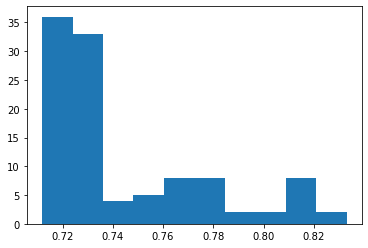

In [18]:
plt.hist(k_precision_1)

(array([ 1., 18., 53.,  9.,  3.,  3.,  2.,  4., 12.,  3.]),
 array([0.93096234, 0.93693847, 0.94291459, 0.94889071, 0.95486683,
        0.96084295, 0.96681907, 0.9727952 , 0.97877132, 0.98474744,
        0.99072356]),
 <BarContainer object of 10 artists>)

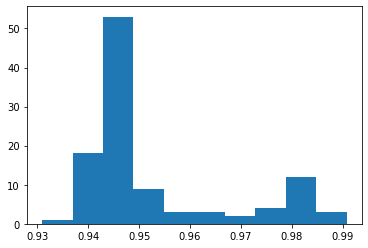

In [19]:
plt.hist(k_precision_10)

(array([33., 39.,  4.,  5.,  4.,  5.,  4.,  6.,  7.,  1.]),
 array([0.92042186, 0.92708097, 0.93374009, 0.9403992 , 0.94705831,
        0.95371742, 0.96037654, 0.96703565, 0.97369476, 0.98035387,
        0.98701299]),
 <BarContainer object of 10 artists>)

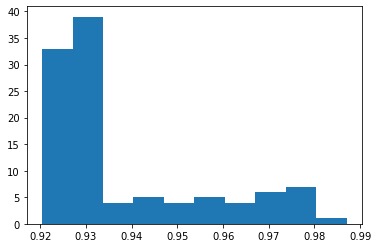

In [15]:
#k_precision_5 = k_precision
plt.hist(k_precision_5)

In [10]:
one_l = [False, True]
np.sum(one_l) / len(one_l)

0.5

In [59]:
res_df = pd.DataFrame(zip(k_precision_1, k_precision_3, k_precision_5, k_precision_10, k_precision_20, k_precision_30, k_precision_50),
                     columns=['precision_1', 'precision_3', 'precision_5', 'precision_10', 'precision_20', 'precision_30', 'precision_50'])
res_df

,precision_1,precision_3,precision_5,precision_10,precision_20,precision_30,precision_50
0,0.733498,0.922442,0.958746,0.974422,0.982673,0.982673,0.982673
1,0.730250,0.903661,0.921965,0.941233,0.949904,0.949904,0.949904
2,0.780612,0.948980,0.969388,0.984694,0.989796,0.989796,0.989796
3,0.744681,0.918594,0.937095,0.950971,0.958372,0.958372,0.958372
4,0.720539,0.901515,0.925926,0.943603,0.952020,0.952020,0.952020
...,...,...,...,...,...,...,...
103,0.724138,0.904121,0.926829,0.943650,0.952061,0.952061,0.952061
104,0.725539,0.907960,0.928690,0.944444,0.951907,0.951907,0.951907
105,0.724719,0.899813,0.921348,0.940075,0.949438,0.949438,0.949438
106,0.721298,0.904326,0.927621,0.944260,0.951747,0.951747,0.951747


In [60]:
res_df.to_csv('precision_k.csv')

In [32]:
np.sum(res_df['precision_10']  - res_df['precision_5'])

1.5529545092765833

(array([ 7.,  0., 26., 28.,  9.,  2.,  2.,  2.,  0.,  2.,  1.,  2.,  2.,
         2.,  0.,  2.,  2.,  1.,  0.,  1.,  3.,  2.,  4.,  0.,  6.,  0.,
         1.,  0.,  0.,  1.]),
 array([0.92042186, 0.92264156, 0.92486127, 0.92708097, 0.92930068,
        0.93152038, 0.93374009, 0.93595979, 0.93817949, 0.9403992 ,
        0.9426189 , 0.94483861, 0.94705831, 0.94927802, 0.95149772,
        0.95371742, 0.95593713, 0.95815683, 0.96037654, 0.96259624,
        0.96481594, 0.96703565, 0.96925535, 0.97147506, 0.97369476,
        0.97591447, 0.97813417, 0.98035387, 0.98257358, 0.98479328,
        0.98701299]),
 <BarContainer object of 30 artists>)

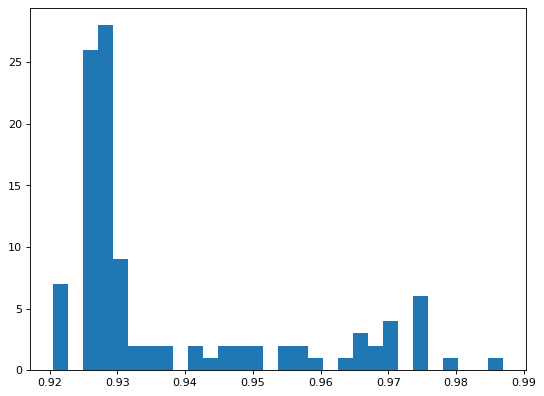

In [40]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(k_precision_5, bins=30)

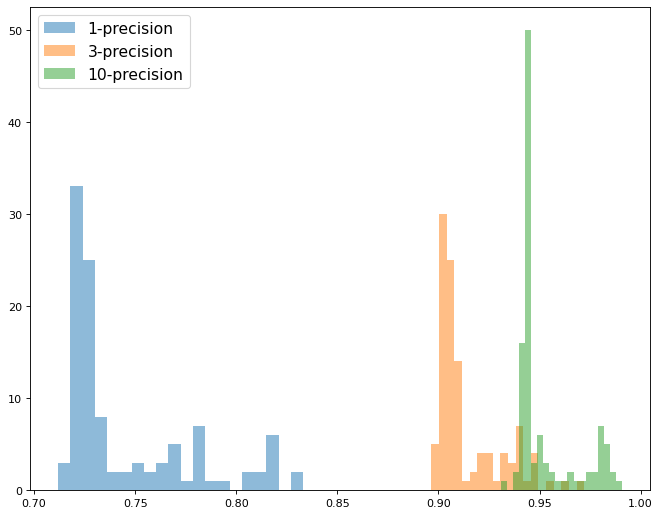

In [100]:
plt.figure(figsize=(10, 8), dpi=80)
data1 = res_df['precision_1']
data2 = res_df['precision_3']
data3 = res_df['precision_10']
plt.hist(data1, bins=20, alpha=0.5, label="1-precision")
plt.hist(data2, bins=20, alpha=0.5, label="3-precision")
plt.hist(data3, bins=20, alpha=0.5, label="10-precision")
# plt.xlabel("Precision", size=14)
# plt.ylabel("Frequency", size=14)
plt.legend(loc='best', prop={'size': 14})
plt.savefig("hist_precision_1_3_10.png")

In [61]:
res_df.mean(axis=0)

precision_1     0.744844
precision_3     0.914381
precision_5     0.937767
precision_10    0.952146
precision_20    0.959248
precision_30    0.959248
precision_50    0.959248
dtype: float64

In [69]:
precision_mean = res_df.mean(axis=0)
x_vals = [1, 3, 5, 10, 20, 30, 50]

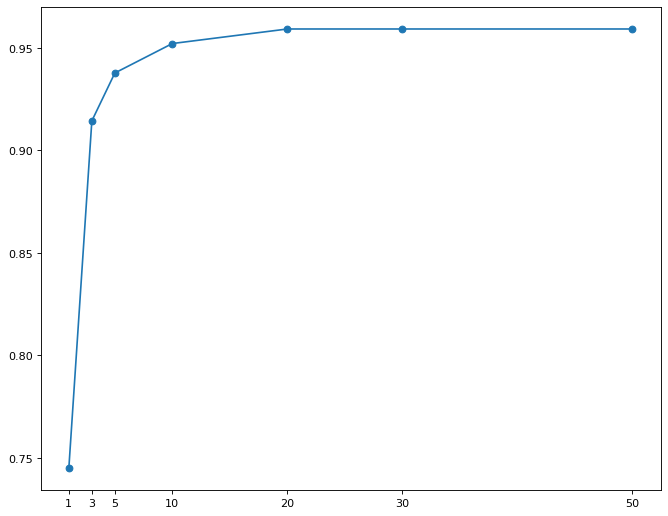

In [70]:
plt.figure(figsize=(10, 8), dpi=80)
plt.xticks(x_vals)
plt.plot(x_vals, precision_mean, "-o")

In [ ]:
x = [1,2,3,4,5]
y = [2,1,3,6,7]

plt.plot(x, y, "-o")
x0 = [2]
y0 = [1]
plt.plot(x0, y0, "s")

plt.show()